# Imports & General stuff

In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

This notebook is dedicated to datasets analysis. 

Here we will concentrate on connecting our datasets into one dataframe that will later be used to extract meaningful information that can help us answer our research questions. 

In addition, data cleaning is performed where necessary since we will not use all the data provided. The goal of this notebook is to make data as easy as possible to use for future plotting and data story writing.

So, let's dive into our data!

In [12]:
import os
import re
import json
import time
import datetime
from functools import reduce
from itertools import product

from json import load, JSONDecodeError
from functional import pseq, seq
import pandas as pd
import pandas_profiling
import requests
import pathlib

# necessary to load the utils, which are in src
import sys
sys.path.append('../src')

from utils import file, logging
from utils.statement_handling import extract_information, safe_json_read

from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import utils.statement_handling as SH
reload(SH)

<module 'utils.statement_handling' from '../src/utils/statement_handling.py'>

In [3]:
def group_and_count(df, groupby_column, with_pct=False, with_avg=False):
    result = df.groupby(groupby_column).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
    if with_pct:
        result['count_pct'] = result['count'] / result['count'].sum()
    if with_avg:
        result['count_avg'] = result['count'].mean()
    return result

In [4]:
directory_liar_dataset = "../data/liar_dataset"
directory_statements = f"{directory_liar_dataset}/statements"
directory_visualizations = "../docs/data_insight"
directory_election_results = "../data/election_results"
directory_county_data = "../data/county_data"

# Statements

In [5]:
statements = seq(pathlib.Path(directory_statements).iterdir()).map(safe_json_read)\
                               .filter(lambda x: len(x) > 0)\
                               .map(extract_information)\
                               .to_pandas()

statements['statement_date'] = pd.to_datetime(statements['statement_date'])
statements.head()

ERROR:root:File ../data/liar_dataset/statements/5355.json is empty or something...
ERROR:root:File ../data/liar_dataset/statements/9.json is empty or something...


,author_name_slug,context,label,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement,statement_date,statement_id,statement_type,statement_type_description,subject
0,lauren-carroll,a speech at Northwestern University,mostly-true,2014-10-08T14:09:46,President,Barack,Illinois,Obama,The cost of health care is now the single-bigg...,2014-10-02,10039,Claim,blog post,Deficit
1,manuela-tobias,in an ad,barely-true,2017-08-25T11:24:04,,,,Senate Leadership Fund,Says Kelli Ward hosted a town hall on chemtrai...,2017-08-22,14464,Claim,blog post,Candidate Biography
2,brittany-alana-davis,remarks,mostly-true,2012-08-21T16:40:06,U.S. representative from Fort Myers,Connie,Florida,Mack,A small business in my district needed 31 diff...,2012-08-11,6501,Claim,blog post,Government regulation
3,dan-levy,a speech to the AFL-CIO Convention,barely-true,2016-04-06T13:02:13,Presidential candidate,Hillary,New York,Clinton,When mentioning Villanova&rsquo;s buzzer-beati...,2016-04-06,12192,Claim,blog post,Sports
4,c-eugene-emery,a television interview,false,2011-05-31T00:01:00,"President, Rhode Society for the Prevention of...",E.J.,Rhode Island,Finocchio,"Most of your serial killers, most of your peop...",2011-04-24,3824,Claim,blog post,Animals


In [6]:
statements.shape

(15471, 14)

# Label counts

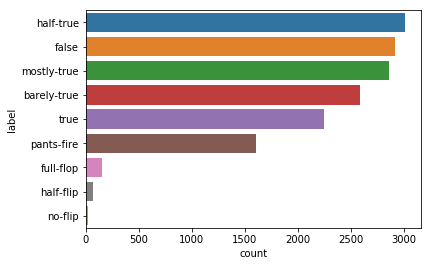

In [14]:
sns.barplot(data=group_and_count(statements, 'label'), x='count', y='label')
plt.savefig('../docs/images/label_counts_overall.png')

In [42]:
statements[['statement_date']].describe()

,statement_date
count,15471
unique,3555
top,2011-10-11 00:00:00
freq,26
first,1995-04-01 00:00:00
last,2018-11-22 00:00:00


[1995,
 2000,
 2002,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018]

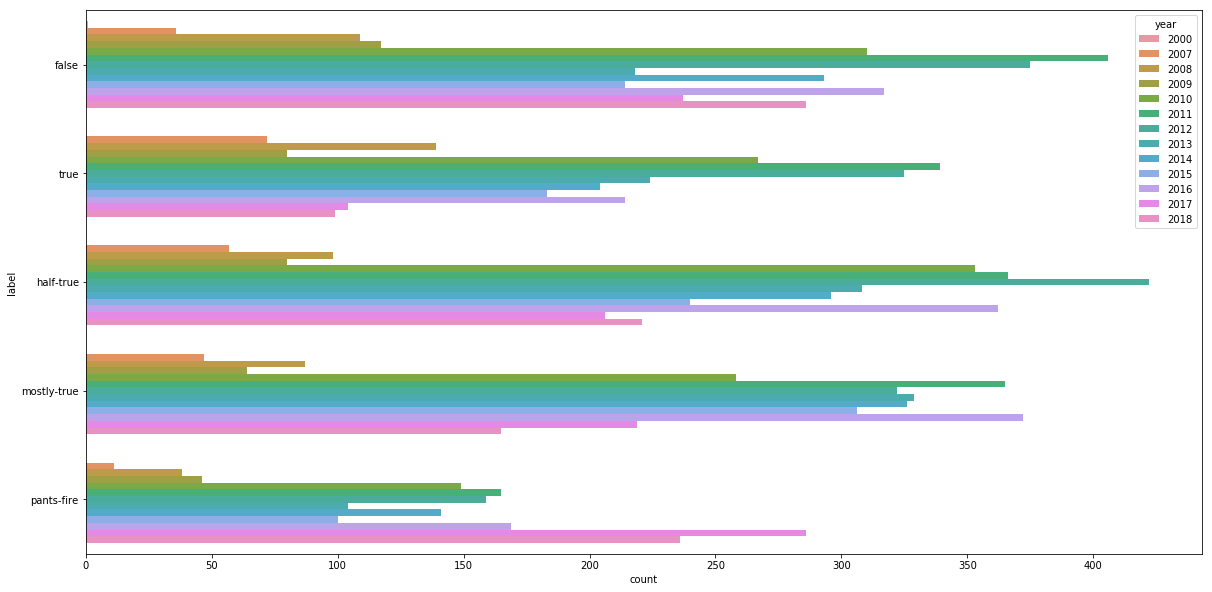

In [47]:
a = statements['statement_date'].dt.year
b = a.value_counts().index
b = sorted(list(b))

def add_year(df, year):
    df['year'] = year
    return df

truhometer_labels = ['pants-fire', 'false', 'mostly-false', 'half-true', 'mostly-true', 'true']
only_truthometer_label_idx = statements['label'].isin(truhometer_labels)

d = pd.concat([add_year(group_and_count(statements.loc[(statements['statement_date'].dt.year == year) & only_truthometer_label_idx,: ], 'label'), year) for year in b])
f = plt.figure(figsize=(20, 10))
sns.barplot(data=d, x='count', y='label', hue='year')

In [29]:
d.dtypes

label    object
count     int64
year      int64
dtype: object

So how to regroup all these or part of these?
We can use the mean of communication for example:
radio/tv/facebook/twitter/internet
and these classes can have overlap...

In [7]:
statements['clean_context'] = statements['context'].apply(SH.clean_up_context)

In [457]:
def _count_for_last_name_(df, last_name):
    return group_and_count(df.loc[df['speaker_last_name'].str.contains(last_name, flags=re.IGNORECASE), :], 'label', with_pct=True)\
            .rename(columns={'count': f'count_{last_name}', 'count_pct': f'count_pct{last_name}'})

In [458]:
pd.merge(_count_for_last_name_(statements, 'obama'), _count_for_last_name_(statements, 'trump'), on='label')

,label,count_obama,count_pctobama,count_trump,count_pcttrump
0,mostly-true,169,0.267829,74,0.112977
1,half-true,162,0.256735,93,0.141985
2,true,127,0.201268,30,0.045802
3,false,73,0.115689,217,0.331298
4,barely-true,71,0.112520,137,0.209160
5,full-flop,13,0.020602,7,0.010687
6,pants-fire,9,0.014263,97,0.148092


In [552]:
statements['statement_date'].describe()

count                   15471
unique                   3555
top       2011-10-11 00:00:00
freq                       26
first     1995-04-01 00:00:00
last      2018-11-22 00:00:00
Name: statement_date, dtype: object

# Federal Election Results

## Loading

In [17]:
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 300

In [18]:
from itertools import product
from functools import reduce

def add_ending(f):
    """ File ending depending on a year
    
    Parameters
    ----------
    f: str
        Name of the file
    
    ToDos:
    - do 2012 it's a special snowflake
    """
    if '2016' in f:
        return f"{f}x"
    else:
        return f


election_files = [(add_ending(f'{directory_election_results}/federalelections{year}.xls'), year) for year in [2014, 2016]]

In [107]:
election_results_cols_of_interest = ['CANDIDATE NAME', 'PRIMARY VOTES', 'PRIMARY %', 'STATE']

def fix_columns_election_results(df, year, type_):
    """we are only interested in the primary votes, since these reflect the opinion the most"""
    #print(df.columns)
    df = df.loc[:, election_results_cols_of_interest].rename(columns={
        'CANDIDATE NAME': 'candidate_name',
        'PRIMARY VOTES': f'primary_votes_{type_.lower()}_{year}',
        'PRIMARY %': f'primary_votes_{type_.lower()}_{year}_pct',
        'STATE': f'state_{type_.lower()}_{year}'})
              
    return df


def get_only_voting_results(df):
    return df.loc[df['CANDIDATE NAME'].notna() & df['PRIMARY VOTES'].notna() & df['CANDIDATE NAME'].ne('Scattered') & df['CANDIDATE NAME'].ne('All Others'), :]


def prep_election_results(df, year, type_):
    return fix_columns_election_results(get_only_voting_results(df), year, type_)

In [257]:
def combine_first(df, columns, target_column_name, drop_cols=False):
    df = df.copy()
    df[target_column_name] = df[columns[0]]
    for c in columns[1:]:
        df[target_column_name] = df[target_column_name].combine_first(df[c])
        
    if drop_cols:
        df = df.drop(columns=columns)
        
    return df

In [124]:
def handle_states(df):
    df = combine_first(df, [c for c in df.columns if 'state' in c], 'state')
    return df.drop(columns=[c for c in df.columns if 'state' in c and c != 'state'])

In [231]:
election_results = [prep_election_results(pd.read_excel(f, sheet_name=f'{year} US {type_} Results by State'), year, type_) for (f, year), type_ in product(election_files, ['Senate', 'House'])]

# we let the results as they are, merge, and then check if the person is a senator or a member of the house based on the other results
# yes they did a spelling mistake
election_results += [prep_election_results(pd.read_excel(f'{directory_election_results}/federalelections2012.xls', sheet_name=f'2012 US House & Senate Resuts'), 2012, 'all')]
election_results = reduce(lambda acc, el: pd.merge(acc, el, on='candidate_name', how='outer'), election_results)

election_results = election_results.loc[election_results['primary_votes_all_2012'].ne('Convention') & election_results['primary_votes_all_2012_pct'].ne('Convention'), :] # No clue what they mean by that, but we don't have any other data for these guys anyway

election_results = handle_states(election_results)

# Converting pct fields to numbers
for c in election_results.columns:
    if c.startswith('primary') and c.endswith('pct'):
        election_results[c] = pd.to_numeric(election_results[c])

## Number of useful politicians / election results

**Comments**

- currently only politicians which participated in at least two elections are considered "interesting"


**TODO**

- for the politician for which we have data for a prior election, find out why they are no longer part of it

In [127]:
election_results.head()

,candidate_name,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct,primary_votes_all_2012,primary_votes_all_2012_pct,state
0,"Sessions, Jeff",Unopposed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alabama
1,"Sullivan, Dan",44740,0.400548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alaska
2,"Miller, Joe",35904,0.321441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alaska
3,"Treadwell, Mead",27807,0.248950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alaska
4,"Jaramillo, John M.",3246,0.029061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alaska


In [155]:
idx_multiple_election_results = election_results.loc[:, [c for c in election_results.columns if any((c.endswith(str(y)) for y in [2012, 2014, 2016]))]].notna().sum(axis=1) > 1

print(f"we have multple election results for {idx_multiple_election_results.sum()} politicians ({idx_multiple_election_results.mean()}%)")

we have multple election results for 1110 politicians (0.19618239660657477%)


In [24]:
election_results[idx_multiple_election_results].head()

,CANDIDATE NAME,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct,primary_votes_all_2012,primary_votes_all_2012_pct
16,"Gardner, Cory",338324,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,49340,1
19,"Wade, Kevin",18181,0.756627,NaN,NaN,NaN,NaN,NaN,NaN,Unopposed,NaN
32,"Schatz, Brian",115445,0.493460,NaN,NaN,162905,0.861662,NaN,NaN,NaN,NaN
33,"Hanabusa, Colleen Wakako",113663,0.485843,NaN,NaN,NaN,NaN,74022,0.803757,NaN,NaN
36,"Roco, John P.",4425,0.123572,NaN,NaN,3956,0.110303,NaN,NaN,545,0.0112848


# Influence of statements on election results

## joining statements and election results

In [254]:
# we join on last names and state
election_results[['candidate_last_name',  'candidate_first_name', 'candidate_name_misc']] = election_results['candidate_name'].str.split(', ', expand=True)

t = election_results.loc[idx_multiple_election_results, ['state'] + [c for c in election_results.columns if c.endswith('pct') or c.startswith('candidate') and not c.endswith('misc')]]
statements_with_elections =  statements.merge(t, left_on=['speaker_last_name', 'speaker_home_state'], right_on=['candidate_last_name', 'state'])

## Simpliyfing the label

In [215]:
labels_of_interest = ['false',
                      'mostly-true',
                      'half-true',
                      'barely-true',
                      'true',
                      'pants-fire',
                      #'full-flop',
                      #'half-flip',
                      #'no-flip',
                     ]

statements_with_elections = statements_with_elections.loc[statements_with_elections['label'].isin(labels_of_interest), :]

def simplify_label(l):
    if l in ['pants-fire', 'false']:
        return 'false'
    else:
        return 'true'


statements_with_elections['simple_label'] = statements_with_elections['label'].apply(simplify_label)

In [246]:
def simplify_votes(df):
    df = df.copy()
    for y in [2014, 2016]:
        cols = [c for c in df.columns if str(y) in c]
        df = combine_first(df, cols, f'primary_votes_{y}', drop_cols=True)
        
    return df.rename(columns={'primary_votes_all_2012_pct': 'primary_votes_2012'})

In [224]:
statements_with_elections = simplify_votes(statements_with_elections)

## Counting lies in between elections

- we know for each candidate the election date -> sum statements between these dates -> compare with votes
- 

In [225]:
statements_with_elections

,author_name_slug,context,label,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement,statement_date,statement_id,statement_type,statement_type_description,clean_context,statement_month,state,candidate_name,primary_votes_2012,candidate_last_name,candidate_first_name,simple_label
0,nadia-pflaum,in a press conference,barely-true,2016-06-10T10:47:12,Member of Congress,Joyce,Ohio,Beatty,"In Ohio, each year an estimated 1,000 children become victims of human trafficking, and over 3,000 more are at risk.",2016-05-25,12487,Claim,blog post,tv,201605,Ohio,"Beatty, Joyce",0.383209,Beatty,Joyce,true
1,sabrina-eaton,a floor speech in the House of Representatives,mostly-true,2013-02-08T06:00:00,Member of Congress,Joyce,Ohio,Beatty,"Says each year approximately 30,000 people in the United States die as a result of gunfire, and about 80,000 people are wounded.<br />&nbsp;",2013-01-14,7350,Claim,blog post,speech,201301,Ohio,"Beatty, Joyce",0.383209,Beatty,Joyce,true
2,miriam-valverde,a CNN town hall,barely-true,2018-02-23T13:59:49,,Ted,Florida,Deutch,Mass shootings went up 200 percent in the decade after the assault weapons ban expired.,2018-02-21,15071,Claim,blog post,tv,201802,Florida,"Deutch, Ted",NaN,Deutch,Ted,true
3,becky-bowers,a letter with other Florida lawmakers to HHS Secretary Kathleen Sebelius,true,2013-08-08T12:22:59,,Ted,Florida,Deutch,Says Florida refused to allow the&nbsp;insurance commissioner to negotiate lower rates with companies or refuse rates that are too high under Obamacare.,2013-08-01,8130,Claim,blog post,_ignore_,201308,Florida,"Deutch, Ted",NaN,Deutch,Ted,true
4,jacob-geiger,an e-mail newsletter and House floor speech.,barely-true,2011-03-22T15:02:30,U.S. Congressman,Morgan,Virginia,Griffith,"Not even expensive bottled water, like Perrier and Evian, are of good enough quality to pump out of mines in Southwest Virginia, according to the EPA regulation.",2011-02-18,3458,Claim,blog post,speech,201102,Virginia,"Griffith, H. Morgan",NaN,Griffith,H. Morgan,true
5,nancy-madsen-virginia,congressional testimony.,true,2014-04-14T11:30:00,U.S. Congressman,Morgan,Virginia,Griffith,"From 1972 until 2011, the number of EPA employees increased by 107 percent while the number of total federal personnel decreased by 15 percent.&nbsp;",2014-03-25,9189,Claim,blog post,others,201403,Virginia,"Griffith, H. Morgan",NaN,Griffith,H. Morgan,true
6,nancy-madsen-virginia,an interview.,false,2012-04-09T06:00:00,U.S. Congressman,Morgan,Virginia,Griffith,"On most things except witch trials, Virginia will always have been first.",2012-04-03,5703,Claim,blog post,interview,201204,Virginia,"Griffith, H. Morgan",NaN,Griffith,H. Morgan,false
7,jacob-geiger,a newsletter.,barely-true,2011-03-31T17:47:30,U.S. Congressman,Morgan,Virginia,Griffith,"Originally, Democrats promised that if you liked your health care plan, you could keep it. One year later we know that you need a waiver to keep your plan.",2011-03-25,3507,Claim,blog post,article,201103,Virginia,"Griffith, H. Morgan",NaN,Griffith,H. Morgan,true
8,sean-gorman,a news release.,barely-true,2013-06-17T06:00:00,U.S. Congressman,Morgan,Virginia,Griffith,The Government Accountability Office estimated (Obamacare) will add to the long-term deficit by $6.2 trillion.,2013-05-16,7906,Claim,blog post,press release,201305,Virginia,"Griffith, H. Morgan",NaN,Griffith,H. Morgan,true
9,jacob-geiger,a newsletter.,false,2011-03-11T07:55:20,U.S. Congressman,Morgan,Virginia,Griffith,"A new ruling by the EPA would force dairy farmers to comply with the Spill Prevention, Control and Countermeasure Program when dealing with spilt milk -- the same regulations oil and natural gas producers must follow.&nbsp;",2011-02-11,3399,Claim,blog post,article,201102,Virginia,"Griffith, H. Morgan",NaN,Griffith,H. Morgan,false


In [430]:
periods = [(201011, 201211), (201211, 201411), (201411, 201611), (200811, 201211), (201211, 201611)]

def agg_for_years(statements, ys):
    statements = statements.loc[statements['statement_month'].lt(ys[1]) & statements['statement_month'].gt(ys[0])]
    statements['simple_label'] = statements['label'].apply(simplify_label)

    return statements.groupby(['speaker_last_name', 'speaker_home_state', 'simple_label']).size().reset_index(name='count_{0}_{1}'.format(str(ys[0])[:4], str(ys[1])[:4]))



simple_votes_2012_2014 = simple_votes.loc[simple_votes['primary_votes_2012'].notnull() & simple_votes['primary_votes_2014'].notnull()]
statements_with_elections_2012_2014 =  simple_votes_2012_2014.merge(agg_for_years(statements, periods[0]), right_on=['speaker_last_name', 'speaker_home_state'], left_on=['candidate_last_name', 'state'])\
    .merge(agg_for_years(statements, periods[1]), on=['speaker_last_name', 'speaker_home_state', 'simple_label'])

simple_votes_2014_2016 = simple_votes.loc[simple_votes['primary_votes_2014'].notnull() & simple_votes['primary_votes_2016'].notnull()]
statements_with_elections_2014_2016 =  simple_votes_2014_2016.merge(agg_for_years(statements, periods[1]), right_on=['speaker_last_name', 'speaker_home_state'], left_on=['candidate_last_name', 'state'])\
    .merge(agg_for_years(statements, periods[2]), on=['speaker_last_name', 'speaker_home_state', 'simple_label'])

simple_votes_2012_2016 = simple_votes.loc[simple_votes['primary_votes_2012'].notnull() & simple_votes['primary_votes_2016'].notnull()]
statements_with_elections_2012_2016 =  simple_votes_2012_2016.merge(agg_for_years(statements, (200811, 201211)), right_on=['speaker_last_name', 'speaker_home_state'], left_on=['candidate_last_name', 'state'])\
    .merge(agg_for_years(statements, (201211, 201611)), on=['speaker_last_name', 'speaker_home_state', 'simple_label'])

coi_p1 = ['state', 'candidate_name', 'primary_votes_2012', 'primary_votes_2014', 'simple_label', 'count_2010_2012', 'count_2012_2014']
coi_p2 = ['state', 'candidate_name', 'primary_votes_2016', 'simple_label', 'count_2014_2016'] + ['speaker_last_name', 'speaker_home_state']
coi_p3 = ['state', 'candidate_name', 'simple_label', 'count_2008_2012', 'count_2012_2016']

combined = statements_with_elections_2012_2014.loc[:, coi_p1]\
    .merge(statements_with_elections_2014_2016.loc[:, coi_p2], on=['state', 'candidate_name', 'simple_label'], how='outer')\
    .merge(statements_with_elections_2012_2016.loc[:, coi_p3], on=['state', 'candidate_name', 'simple_label'], how='outer')

/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [431]:
import numpy as np

def _period_year_(period):
    return [str(p)[:4] for p in period]

def ratio_for_period(statements, period):
    """Calculates the ratio between false and true statements for the given period (defined as a tuple of two "year-months").
    If no true statements exists the ratio will be `np.inf`.
    
    Example:
    
    >>> ratio_for_period(statements, (201011, 201211))
    """
    _t = agg_for_years(statements, period)

    _t = pd.pivot_table(_t, index=['speaker_last_name', 'speaker_home_state'], values='count_{0}_{1}'.format(*_period_year_(period)), columns='simple_label', ).reset_index()
    _t = _t.loc[_t['false'].notnull()] # we are only interested in the impact of lies -> drop the rows for which we don't have any lies
    _t['ratio'] = np.inf # 
    _h = _t['true'].notnull()
    _t.loc[_t['true'].notnull(), 'ratio'] = _t.loc[_h, 'false'] / _t.loc[_h, 'true']
    return _t[['ratio', 'speaker_last_name', 'speaker_home_state']].rename(columns={'ratio': 'ratio_{0}_{1}'.format(*_period_year_(period))})

In [432]:
true_false_ratios = reduce(lambda acc, el: acc.merge(el, on=['speaker_last_name', 'speaker_home_state'], how='outer'), [ratio_for_period(statements, p) for p in periods])

/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [435]:
_t[:3]

,state,candidate_name,primary_votes_2012,primary_votes_2014,count_2010_2012,count_2012_2014,primary_votes_2016,count_2014_2016,speaker_last_name,speaker_home_state,count_2008_2012,count_2012_2016,ratio_2010_2012,ratio_2012_2014,ratio_2014_2016,ratio_2008_2012,diff_votes_2012_2014,diff_votes_2014_2016,diff_votes_2012_2016,diff_ratio_2012_2014
0,New Hampshire,"Brown, Scott P.",0.994554,0.009041,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.985513,NaN,NaN,NaN
1,California,"Issa, Darrell",0.610908,0.618749,1.0,1.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,-0.007841,NaN,NaN,NaN
2,Florida,"Wilson, Frederica S.",0.663808,0.804283,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.140475,NaN,NaN,NaN


In [437]:
_t = combined.drop_duplicates(subset=['state', 'candidate_name']).drop(columns=['simple_label'])

# not very many people left... 7! but the primary votes for 2016 are missing
_t = _t.merge(true_false_ratios, on=['speaker_last_name', 'speaker_home_state'], how='outer')
for l, r in [(2012, 2014), (2014, 2016), (2012, 2016)]:
    _t[f'diff_votes_{l}_{r}'] = _t[f'primary_votes_{l}'] - _t[f'primary_votes_{r}']
    #_t[f'diff_ratio_{l}_{r}'] = _t[f'ratio_2010_2012'] - _t['ratio_2012_2014']
_t.loc[(_t['diff_votes_2012_2014'].notnull() | _t['diff_votes_2012_2016'].notnull() | _t['diff_votes_2014_2016'].notnull()), sorted(_t.columns)]

,candidate_name,count_2008_2012,count_2010_2012,count_2012_2014,count_2012_2016,count_2014_2016,diff_votes_2012_2014,diff_votes_2012_2016,diff_votes_2014_2016,primary_votes_2012,primary_votes_2014,primary_votes_2016,ratio_2008_2012,ratio_2010_2012,ratio_2012_2014,ratio_2012_2016,ratio_2014_2016,speaker_home_state,speaker_last_name,state
0,"Brown, Scott P.",NaN,1.0,6.0,NaN,NaN,0.985513,NaN,NaN,0.994554,0.009041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Hampshire
1,"Issa, Darrell",2.0,1.0,1.0,1.0,NaN,-0.007841,NaN,NaN,0.610908,0.618749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California
2,"Wilson, Frederica S.",NaN,1.0,1.0,NaN,NaN,-0.140475,NaN,NaN,0.663808,0.804283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Florida
3,"Labrador, Raul R.",1.0,1.0,1.0,1.0,NaN,0.020846,NaN,NaN,0.806493,0.785647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Idaho
4,"Hoyer, Steny H.",NaN,2.0,1.0,NaN,NaN,-0.153222,NaN,NaN,0.846778,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maryland
5,"Van Hollen, Chris",NaN,3.0,1.0,NaN,NaN,0.009273,NaN,NaN,0.922086,0.912813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maryland
6,"Pascrell, Bill, Jr.",7.0,4.0,1.0,1.0,NaN,-0.388210,NaN,NaN,0.611790,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Jersey
7,"Johnson, Bill",2.0,2.0,1.0,1.0,NaN,-0.160607,NaN,NaN,0.839393,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ohio
8,"Boehner, John A.",NaN,8.0,4.0,NaN,NaN,0.123195,NaN,NaN,0.838155,0.714960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ohio
9,"Kaptur, Marcy",10.0,9.0,2.0,2.0,NaN,-0.438205,NaN,NaN,0.561795,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ohio


In [416]:
combined.loc[:, sorted(combined.columns)]

,candidate_name,count_2008_2012,count_2010_2012,count_2012_2014,count_2012_2016,count_2014_2016,primary_votes_2012,primary_votes_2014,primary_votes_2016,simple_label,speaker_home_state,speaker_last_name,state
0,"Brown, Scott P.",NaN,1.0,6.0,NaN,NaN,0.994554,0.009041,NaN,true,NaN,NaN,New Hampshire
1,"Brown, Scott P.",NaN,1.0,6.0,NaN,NaN,0.994554,0.498554,NaN,true,NaN,NaN,New Hampshire
2,"Issa, Darrell",2.0,1.0,1.0,1.0,NaN,0.610908,0.618749,NaN,false,NaN,NaN,California
3,"Wilson, Frederica S.",NaN,1.0,1.0,NaN,NaN,0.663808,0.804283,NaN,true,NaN,NaN,Florida
4,"Labrador, Raul R.",1.0,1.0,1.0,1.0,NaN,0.806493,0.785647,NaN,true,NaN,NaN,Idaho
5,"Hoyer, Steny H.",NaN,2.0,1.0,NaN,NaN,0.846778,1.000000,NaN,true,NaN,NaN,Maryland
6,"Van Hollen, Chris",NaN,3.0,1.0,NaN,NaN,0.922086,0.912813,NaN,true,NaN,NaN,Maryland
7,"Pascrell, Bill, Jr.",7.0,4.0,1.0,1.0,NaN,0.611790,1.000000,NaN,true,NaN,NaN,New Jersey
8,"Johnson, Bill",2.0,2.0,1.0,1.0,NaN,0.839393,1.000000,NaN,true,NaN,NaN,Ohio
9,"Boehner, John A.",NaN,8.0,4.0,NaN,NaN,0.838155,0.714960,NaN,false,NaN,NaN,Ohio


In [400]:
statements

,author_name_slug,context,label,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement,statement_date,statement_id,statement_type,statement_type_description,clean_context,statement_month
0,lauren-carroll,a speech at Northwestern University,mostly-true,2014-10-08T14:09:46,President,Barack,Illinois,Obama,The cost of health care is now the single-biggest factor driving down the federal budget deficit.,2014-10-02,10039,Claim,blog post,speech,201410
1,manuela-tobias,in an ad,barely-true,2017-08-25T11:24:04,,,,Senate Leadership Fund,Says Kelli Ward hosted a town hall on chemtrail conspiracy theories and is open to sponsoring chemtrails legislation.,2017-08-22,14464,Claim,blog post,ad,201708
2,brittany-alana-davis,remarks,mostly-true,2012-08-21T16:40:06,U.S. representative from Fort Myers,Connie,Florida,Mack,A small business in my district needed 31 different permits and fees just to be able to expand.,2012-08-11,6501,Claim,blog post,others,201208
3,dan-levy,a speech to the AFL-CIO Convention,barely-true,2016-04-06T13:02:13,Presidential candidate,Hillary,New York,Clinton,"When mentioning Villanova&rsquo;s buzzer-beating win in the national championships, Hillary Clinton said: I love those come-from-behind victories.",2016-04-06,12192,Claim,blog post,speech,201604
4,c-eugene-emery,a television interview,false,2011-05-31T00:01:00,"President, Rhode Society for the Prevention of Cruelty to Animals",E.J.,Rhode Island,Finocchio,"Most of your serial killers, most of your people who commit domestic violence, they start off by abusing animals.",2011-04-24,3824,Claim,blog post,interview,201104
5,dylan-baddour,a Cocks not Glocks call to protest on Facebook,half-true,2016-10-07T19:11:53,protest organized by University of Texas students in August 2016,Cocks,Texas,Not Glocks,You would receive a citation for taking a dildo to class at the University of Texas.,2016-08-24,13221,Claim,blog post,facebook,201608
6,joshua-gillin,Internet posts,pants-fire,2017-04-19T10:58:15,,,,Bloggers,Malia Obama expelled from Harvard.,2017-04-10,14008,Claim,blog post,_ignore_,201704
7,eric-stirgus,an interview,true,2011-03-04T06:00:00,DeKalb County Chief Executive Officer,Burrell,Georgia,Ellis,DeKalb County has cut more money from its general fund budget than any local government in the Atlanta metro region.,2011-02-22,3348,Claim,blog post,interview,201102
8,sue-owen-aas,an email,pants-fire,2012-04-04T16:21:13,,,,Chain email,Says Texas retained the right to have a navy when it joined the United States.,2012-02-19,5681,Claim,blog post,_ignore_,201202
9,eric-stirgus,a press release,true,2012-08-22T06:00:00,,,Georgia,Clayton County Schools,Clayton County Public Schools recently achieved a milestone that has eluded other<br />metropolitan districts across the state by meeting federal guidelines for having a highly qualified staff.,2012-07-26,6511,Claim,blog post,press release,201207


In [399]:
statements[(statements['speaker_first_name'].isnull() | statements['speaker_first_name'].str.strip().eq('')) == False][:1].values

array([['lauren-carroll', 'a speech at Northwestern University',
        'mostly-true', '2014-10-08T14:09:46', 'President', 'Barack',
        'Illinois', 'Obama',
        'The cost of health care is now the single-biggest factor driving down the federal budget deficit.',
        Timestamp('2014-10-02 00:00:00'), 10039, 'Claim', 'blog post ',
        'speech', 201410]], dtype=object)

In [ ]:
## 

In [30]:
# new stuff

In [31]:
statements.columns

Index(['author_name_slug', 'context', 'label', 'ruling_date',
       'speaker_current_job', 'speaker_first_name', 'speaker_home_state',
       'speaker_last_name', 'statement', 'statement_date', 'statement_id',
       'statement_type', 'statement_type_description', 'clean_context'],
      dtype='object')

In [38]:
statements.dtypes

author_name_slug                      object
context                               object
label                                 object
ruling_date                           object
speaker_current_job                   object
speaker_first_name                    object
speaker_home_state                    object
speaker_last_name                     object
statement                             object
statement_date                datetime64[ns]
statement_id                           int64
statement_type                        object
statement_type_description            object
clean_context                         object
dtype: object

In [39]:
statements['statement_month'] = statements['statement_date'].dt.year * 100 + statements['statement_date'].dt.month

/home/sam/.local/bin/miniconda3/envs/sci/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


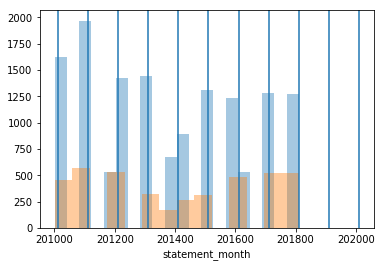

In [70]:
import matplotlib.pyplot as plt

sns.distplot(statements.loc[statements['statement_month'] > 201000, 'statement_month'], kde=False)
sns.distplot(statements.loc[(statements['statement_month'] > 201000) & statements['label'].isin(['false', 'pants-fire']), 'statement_month'], kde=False)


election_dates['month'] = election_dates['Date'].dt.year * 100 + election_dates['Date'].dt.month

for election_day in election_dates.loc[election_dates['month'] > 201000, 'month']:
    plt.axvline(election_day)

In [63]:
election_dates = pd.read_csv('../data/usa_election_dates.csv')
election_dates['Date'] = pd.to_datetime(election_dates['Date'])

election_dates

,Date,Details,Type
0,2000-11-07,"United States elections, 2000",Presidential
1,2001-11-06,"United States elections, 2001",Off-year
2,2002-11-05,"United States elections, 2002",Midterm
3,2003-11-04,"United States elections, 2003",Off-year
4,2004-11-02,"United States elections, 2004",Presidential
5,2005-11-08,"United States elections, 2005",Off-year
6,2006-11-07,"United States elections, 2006",Midterm
7,2007-11-06,"United States elections, 2007",Off-year
8,2008-11-04,"United States elections, 2008",Presidential
9,2009-11-03,"United States elections, 2009",Off-year


In [26]:
# we are only interest in people and they have a first name
lies = lies.loc[lies['speaker_first_name'].notnull(), :]

NameError: name 'lies' is not defined

In [22]:
# to aggregate the statements
lies['statement_year'] = lies['statement_date'].dt.year

# for the merging
lies['speaker_full_name'] = lies['speaker_last_name'] + ', ' + lies['speaker_first_name']

### Cleaning job titles

In [23]:
# todo expand this and check this! this is just a quick and dirty fix
# is it really houseman? probably not...
_job_titles_of_interest = [('senat', 'senator'), ('governor', None), ('congress', 'congressman'), ('mayor', None), ('president', None), ('house', 'houseman'), ('rep', 'houseman')]
job_titles_of_interest = [out if out is not None else j for j, out in _job_titles_of_interest]

def cleaned_job_title(jt):
    jt = str(jt).lower()
    
    for j, out in _job_titles_of_interest:
        if j in jt:
            return out if out is not None else j
    else:
        return jt

lies['speakers_job_title_cleaned'] = lies['speakers_job_title'].apply(cleaned_job_title)

In [24]:
_t = lies.merge(election_results, left_on='speaker_full_name', right_on='CANDIDATE NAME', how='outer')

In [25]:
print(f"found election results for {_t['CANDIDATE NAME'].notnull().sum()} ({_t['CANDIDATE NAME'].notnull().mean()}%) people")

found election results for 4952 (0.328403740301081%) people


In [26]:
votes_cols = [c for c in _t.columns if 'votes' in c]
useful_idx = reduce(lambda acc, el: acc | el, [_t[c].notnull() for c in votes_cols]) & _t['speaker'].notnull() 

print(f"found useful results for {useful_idx.sum()} people")

columns_of_interest = ['label', 'label_as_nb', 'subject', 'speaker', 'speakers_job_title_cleaned', 'state_info', 'party_affiliation', 'context', 'statement_date'] + votes_cols
_t.loc[useful_idx, columns_of_interest]

found useful results for 1461 people


,label,label_as_nb,subject,speaker,speakers_job_title_cleaned,state_info,party_affiliation,context,statement_date,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct
1115,half-true,4.0,"financial-regulation,foreign-policy,water",gwen-moore,houseman,Wisconsin,democrat,a congressional hearing,2016-04-27,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1116,mostly-true,2.0,"crime,criminal-justice,women",gwen-moore,houseman,Wisconsin,democrat,a letter to congressional leadership,2012-12-11,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1117,barely-true,6.0,"city-government,civil-rights,criminal-justice,public-safety,state-budget",gwen-moore,houseman,Wisconsin,democrat,comments to reporters,2015-08-26,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1118,true,0.0,"city-government,infrastructure,transportation",gwen-moore,houseman,Wisconsin,democrat,a newspaper opinion piece,2015-01-14,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1119,false,8.0,"children,crime,criminal-justice,sexuality",gwen-moore,houseman,Wisconsin,democrat,remarks on the House floor,2014-05-29,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1120,pants-fire,10.0,"corrections-and-updates,health-care,women",gwen-moore,houseman,Wisconsin,democrat,tweets,2011-12-27,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1121,true,0.0,"civil-rights,crime,criminal-justice,legal-issues",gwen-moore,houseman,Wisconsin,democrat,an interview,2016-11-18,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1122,mostly-true,2.0,"crime,guns,terrorism,transportation",gwen-moore,houseman,Wisconsin,democrat,a tweet,2016-06-23,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1123,barely-true,6.0,"economy,health-care,medicaid,medicare",gwen-moore,houseman,Wisconsin,democrat,a radio interview,2014-11-11,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1124,false,8.0,"labor,state-budget,state-finances",gwen-moore,houseman,Wisconsin,democrat,a speech at a state Democratic Party dinner,2011-04-30,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN


In [31]:
_t.loc[useful_idx, 'speakers_job_title_cleaned'].value_counts()

senator                                                                                                 580
houseman                                                                                                353
milwaukee county executive                                                                              166
congressman                                                                                             111
nan                                                                                                     101
governor                                                                                                 41
small business owner                                                                                     13
businessman                                                                                              13
retired social worker                                                                                     8
conservative activist       

In [32]:
_t.loc[_t['speakers_job_title_cleaned'].isin(job_titles_of_interest) & useful_idx, columns_of_interest]

,label,label_as_nb,subject,speaker,speakers_job_title_cleaned,state_info,party_affiliation,context,statement_date,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct
1115,half-true,4.0,"financial-regulation,foreign-policy,water",gwen-moore,houseman,Wisconsin,democrat,a congressional hearing,2016-04-27,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1116,mostly-true,2.0,"crime,criminal-justice,women",gwen-moore,houseman,Wisconsin,democrat,a letter to congressional leadership,2012-12-11,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1117,barely-true,6.0,"city-government,civil-rights,criminal-justice,public-safety,state-budget",gwen-moore,houseman,Wisconsin,democrat,comments to reporters,2015-08-26,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1118,true,0.0,"city-government,infrastructure,transportation",gwen-moore,houseman,Wisconsin,democrat,a newspaper opinion piece,2015-01-14,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1119,false,8.0,"children,crime,criminal-justice,sexuality",gwen-moore,houseman,Wisconsin,democrat,remarks on the House floor,2014-05-29,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1120,pants-fire,10.0,"corrections-and-updates,health-care,women",gwen-moore,houseman,Wisconsin,democrat,tweets,2011-12-27,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1121,true,0.0,"civil-rights,crime,criminal-justice,legal-issues",gwen-moore,houseman,Wisconsin,democrat,an interview,2016-11-18,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1122,mostly-true,2.0,"crime,guns,terrorism,transportation",gwen-moore,houseman,Wisconsin,democrat,a tweet,2016-06-23,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1123,barely-true,6.0,"economy,health-care,medicaid,medicare",gwen-moore,houseman,Wisconsin,democrat,a radio interview,2014-11-11,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN
1124,false,8.0,"labor,state-budget,state-finances",gwen-moore,houseman,Wisconsin,democrat,a speech at a state Democratic Party dinner,2011-04-30,NaN,NaN,52413,0.709127,NaN,NaN,NaN,NaN


Now, our dataframe looks like this:

In [33]:
_t.head(1)

,statement_id,label,statement,subject,speaker,speakers_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_as_nb,author_name_slug,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement_date,statement_year,speaker_full_name,speakers_job_title_cleaned,CANDIDATE NAME,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct
0,10540.0,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,4.0,sean-gorman,2015-02-23T00:00:00,State delegate,Scott,Virginia,Surovell,2015-02-04,2015.0,"Surovell, Scott",state delegate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# County Data

In [345]:
# load data file
county_raw = pd.read_csv(f"{directory_county_data}/acs2015_county_data.csv")
US_states = county_raw['State'].unique()
county_raw.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


# DATA SET COMPLETE

At this point, we collected all the columns we need. Let's see how we can clean them:

In [34]:
median_speaker_value = _t.groupby(['statement_year', 'speaker'])['label_as_nb'].median().reset_index()

In [35]:
median_speaker_value[median_speaker_value['statement_year'] == 2016]

,statement_year,speaker,label_as_nb
4334,2016.0,18-percent-american-public,0.0
4335,2016.0,Jack_Graham,8.0
4336,2016.0,aclu-north-carolina,0.0
4337,2016.0,actionaid-k,3.0
4338,2016.0,afscme,4.0
4339,2016.0,afscme-people,2.0
4340,2016.0,al-gore,4.0
4341,2016.0,alan-grayson,3.0
4342,2016.0,alcee-hastings,10.0
4343,2016.0,alex-castellanos,6.0


### Non-People Speakers Handling

Removing non-people (_tweets, facebook posts, etc._) from the dataset:

In [146]:
from nltk import download
download('punkt')
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from collections import Counter

model = 'nlp/stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = 'nlp/stanford-ner-2018-10-16/stanford-ner-3.9.2.jar'
st = StanfordNERTagger(model, jar, encoding='utf-8')

def get_tag(speaker):
    ner_tag = 0
    if type(speaker) == str:
        full_speaker_name = speaker.replace("-", " ").title()

        for sent in sent_tokenize(full_speaker_name):
            tokens = word_tokenize(sent)
            tags = st.tag(tokens)
            
        ner_tag= Counter(dict(tags).values()).most_common(1)[0][0]
        print(tags, " --> ", ner_tag)
    return ner_tag
    

# just to see if/how it works
word = "Twitter-Post-Anna"
get_ner_tag(word)

full_speaker_name = "Barack-Obama"
get_ner_tag(full_speaker_name)

full_speaker_name = 0
get_ner_tag(full_speaker_name)


[nltk_data] Downloading package punkt to C:\Users\Jelena
[nltk_data]     Banjac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[('Twitter', 'ORGANIZATION'), ('Post', 'ORGANIZATION'), ('Anna', 'PERSON')]  -->  ORGANIZATION
[('Barack', 'PERSON'), ('Obama', 'PERSON')]  -->  PERSON


0

In [199]:
import os.path

file_path = 'nlp/speaker_tags.json'

if not os.path.exists(file_path):
    print(f"Total number of values to classify: {len(_t['speaker'].value_counts().index)}")

    words_with_tags = {}
    for word in _t['speaker'].value_counts().index:
        words_with_tags[word] = get_tag(word)
    
    # save tags, since it took ~3h to tag all 3214 unique speakers
    with open(file_path, 'w') as fp:
        json.dump(words_with_tags, fp, indent=4)
else:
    with open(file_path, 'r') as f:
        words_with_tags = json.load(f)
    print(f"Total number of classified values (from file): {len(words_with_tags)}")

Total number of classified values (from file): 3124


In [200]:
_t["speaker_tag"] = _t.apply(lambda row: words_with_tags[row['speaker']] if not pd.isnull(row['speaker']) else row['speaker'], axis=1)
_t[['speaker','speaker_tag']].drop_duplicates()

,speaker,speaker_tag
0,scott-surovell,PERSON
1,barack-obama,PERSON
370,bobby-jindal,PERSON
623,charlie-crist,PERSON
704,robin-vos,PERSON
725,oregon-lottery,PERSON
727,duey-stroebel,PERSON
728,robert-menendez,PERSON
739,bernie-s,PERSON
838,mitt-romney,PERSON


Seems good, so now let's remove non-people from the dataset:

In [201]:
_t.shape

(9803, 37)

In [202]:
_t[_t['speaker_tag'] == "PERSON"].shape

(9803, 37)

We see that we will remove ~5000 statements which are made by (speaker) _Twitter, Facebook, Blog post, Republican Party Texas, etc._

In [203]:
# removing non-people statements
_t = _t[_t['speaker_tag'] == "PERSON"]

### Clean-up Context

In [228]:
_t["context"].value_counts().index.values

array(['an interview', 'a speech', 'a news release', ...,
       'an immigration forum', 'Atlanta City Council meeting',
       'an episode of The Rachel Maddow Show.'], dtype=object)

It would be good to try using the tool that would extract keywords from these phases. Let's use NLTK Rake:

In [327]:
from rake_nltk import Rake, Metric
from collections import Counter

debug = False

def do_keyword_extraction(words):
    if debug: print("---\n", words)
        
    rake_all = Rake()
    rake_all.extract_keywords_from_sentences(_t["context"].value_counts().index.values)

    word_degrees = dict(rake_all.get_word_degrees())
    
    r = Rake()
    r.extract_keywords_from_text(words)

    keywords = dict(r.get_word_degrees())
    
    if debug: print(keywords)
        
    for k, v in keywords.items():
        keywords[k] = word_degrees[k]
    
    if debug: print(keywords)

    return Counter(keywords).most_common(1)[0]

In [328]:
# try to see how it works
text_to_process = "a television interview"
do_keyword_extraction("an interview")
do_keyword_extraction("a television interview")
do_keyword_extraction("a TV interview")

('interview', 158)

In [329]:
_t["context_tag"] = _t.apply(lambda row: do_keyword_extraction(row['context']) if not pd.isnull(row['context']) else row['context'], axis=1)

In [334]:
context_tags = _t[['context','context_tag']]['context_tag'].value_counts()
print(f"Number of different context tags is {len(context_tags)}")
context_tags

Number of different context tags is 271


(interview, 158)       1268
(speech, 175)           877
(debate, 437)           874
(news, 329)             833
(campaign, 406)         729
(press, 228)            656
(ad, 126)               355
(radio, 198)            267
(state, 183)            231
(post, 97)              205
(show, 227)             204
(house, 222)            194
(tweet, 16)             181
(senate, 229)           154
(column, 53)            147
(meeting, 149)          119
(article, 78)           112
(new, 205)               95
(statement, 69)          91
(video, 92)              84
(letter, 33)             81
(email, 48)              81
(website, 72)            75
(ed, 45)                 74
(abc, 23)                70
(texas, 168)             65
(forum, 78)              63
(hearing, 149)           56
(journal, 71)            48
(rally, 45)              46
                       ... 
(reporter, 11)            1
(virginia, 1)             1
(co, 5)                   1
(filibuster, 6)           1
(teleconference, 1) 

We see that the number of context tags is 271, which is a preatty big number. Let's consider decreasing this number and make smaller groups.

In [ ]:
# TODO: make smaller context groups, ideally around 10

In [ ]:
# TODO: implement tagging on the cleaned jobs as well

In [ ]:
# TODO: plot the answers from research questions we have

## Some initial insights

In [346]:
_t['sum_not_so_true'] = _t['pants_on_fire_counts']/(_t['barely_true_counts'] + _t['false_counts'] + _t['half_true_counts'] + _t['mostly_true_counts'] + _t['pants_on_fire_counts'])
number_of_party_affiliation = _t.groupby('party_affiliation')['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation

party_affiliation
republican                      444.294341
democrat                        170.195967
none                             73.311320
newsmaker                         5.250000
talk-show-host                    4.500000
libertarian                       3.333333
independent                       2.666667
business-leader                   2.000000
journalist                        1.666667
green                             1.500000
columnist                         1.181818
tea-party-member                  1.000000
labor-leader                      1.000000
organization                      1.000000
constitution-party                0.666667
liberal-party-canada              0.000000
education-official                0.000000
democratic-farmer-labor           0.000000
ocean-state-tea-party-action      0.000000
county-commissioner               0.000000
state-official                    0.000000
activist                          0.000000
Moderate                          0.

Here are the `party_affiliations` who most lie ordered by their proportion of lies. But we already know that the 2 dominant parties in USA are republican and democrat. We see that there are lots of unknown party affiliations from which we can make identify 2 possibilities

In [347]:
number_of_party_affiliation = _t.groupby(['speaker'])['sum_not_so_true'].sum().sort_values(ascending=False)
number_of_party_affiliation.head(10)

speaker
donald-trump        58.006135
mitt-romney         21.051136
rick-perry          19.636364
michele-bachmann    15.428571
scott-walker        12.173333
newt-gingrich       11.763889
barack-obama        10.446089
rush-limbaugh        9.459459
john-mccain          9.205479
chris-christie       8.987654
Name: sum_not_so_true, dtype: float64

Looking at the dataset content, people above are sorted quantity of lies.

In [348]:
all_contexts = _t['context_tag'].unique()
nb_elements_context = _t.groupby(['context_tag'])['context_tag'].count().sort_values(ascending=False)
nb_elements_context.head(50)

context_tag
(interview, 158)     1268
(speech, 175)         877
(debate, 437)         874
(news, 329)           833
(campaign, 406)       729
(press, 228)          656
(ad, 126)             355
(radio, 198)          267
(state, 183)          231
(post, 97)            205
(show, 227)           204
(house, 222)          194
(tweet, 16)           181
(senate, 229)         154
(column, 53)          147
(meeting, 149)        119
(article, 78)         112
(new, 205)             95
(statement, 69)        91
(video, 92)            84
(letter, 33)           81
(email, 48)            81
(website, 72)          75
(ed, 45)               74
(abc, 23)              70
(texas, 168)           65
(forum, 78)            63
(hearing, 149)         56
(journal, 71)          48
(rally, 45)            46
(cnn, 34)              42
(hall, 78)             39
(tv, 102)              34
(mail, 23)             34
(appearance, 32)       33
(comments, 18)         31
(reporters, 24)        29
(discussion, 31)       27


Looking at the context, it seems that people lie the most during the interviews, then speech, after debates, and so on...

## [misc] One statement content visualization

Let's analyse first row, statement with id `1`. What is the information we get there?

In [190]:
sid = 1.0

In [191]:
_t[_t.statement_id == sid]

,statement_id,label,statement,subject,speaker,speakers_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_as_nb,author_name_slug,ruling_date,speaker_current_job,speaker_first_name,speaker_home_state,speaker_last_name,statement_date,statement_year,speaker_full_name,speakers_job_title_cleaned,CANDIDATE NAME,primary_votes_senate_2014,primary_votes_senate_2014_pct,primary_votes_house_2014,primary_votes_house_2014_pct,primary_votes_senate_2016,primary_votes_senate_2016_pct,primary_votes_house_2016,primary_votes_house_2016_pct,ner_lbl,ner_tag
11184,1.0,pants-fire,The attorney general requires that rape victims pay for the rape kit.,"crime,women",barbara-ann-radnofsky,NaN,NaN,democrat,0.0,0.0,0.0,0.0,1.0,in a Web site video,10.0,meghan-ashford-grooms,2010-01-12T15:52:21,,Barbara Ann,,Radnofsky,2009-10-22,2009.0,"Radnofsky, Barbara Ann",nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PERSON


In [337]:
with open(f"{directory_statements}/{int(sid)}.json", "r") as f:
    data = json.load(f)

Just to visualize JSON hierarchy, run the following cell:

In [ ]:
def go_further(dic, name):
    dict_vis = {"name": name, "children": []}
    for k, v in dic.items():
        if type(v) == str:
            new_el = {"name": k}
        elif type(v) == list:
            if len(v) > 0:
                new_el = go_further(v[0], k)
        elif type(v) == dict:
            new_el = go_further(v, k)
        else:
            new_el = {"name": k}
        dict_vis["children"].append(new_el)
        
    return dict_vis

my_dict = go_further(data, name="statement_info")

with open(f"{directory_visualizations}/data.json", "w") as f:
    json.dump(my_dict, f)

print(f"Checkout visualization by: \n1) cd ../visualizations \n2) python -m http.server \n3) in browser, open: http://localhost:8000/")